
Running Shor for N = 15

--- Attempt 1 ---
Random a: 8
Circuit built: counting=8, target=4, depth=11


/home/eknights1/miniconda3/envs/shor-env/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


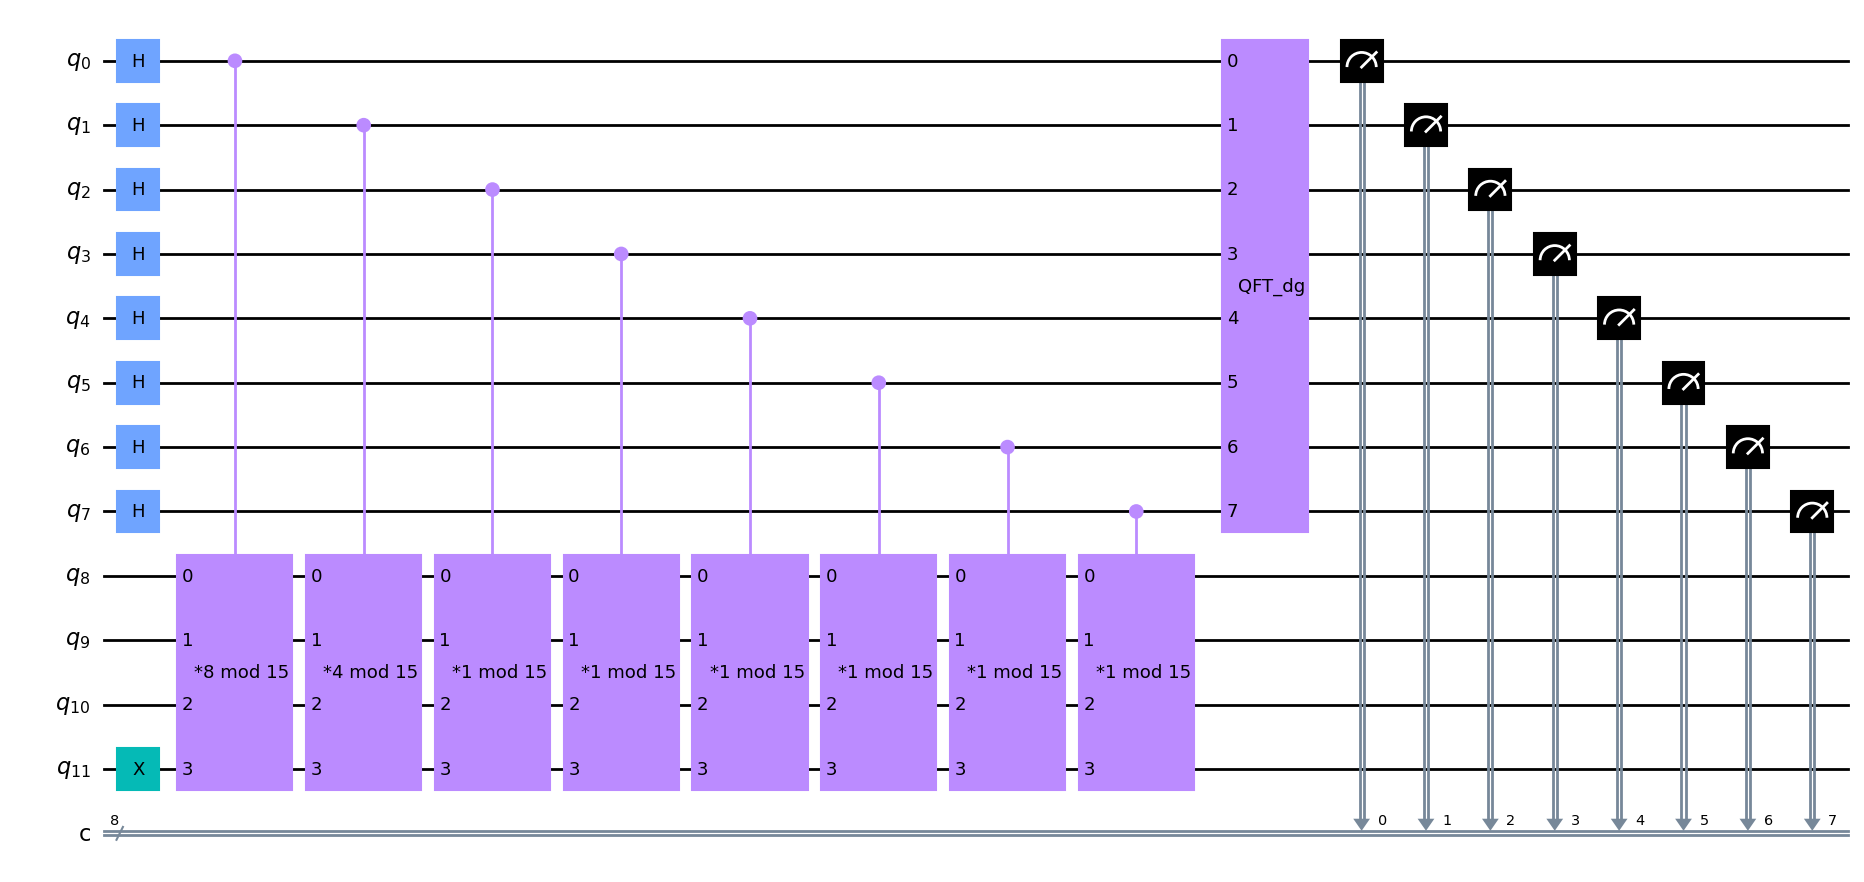

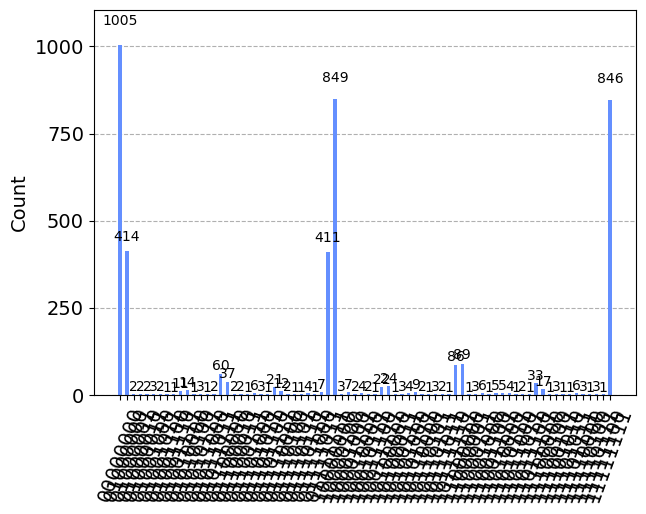

Measured 00000000 → r ≈ 1
Bad r, retrying...

--- Attempt 2 ---
Random a: 12
Immediate gcd factor: 3
Result: (3, 5)

Running Shor for N = 21

--- Attempt 1 ---
Random a: 6
Immediate gcd factor: 3
Result: (3, 7)

SUMMARY
N = 15 → (3, 5)
N = 21 → (3, 7)


In [6]:
# ==========================================================
# Shor Algorithm (Exact CMM version) N 15 & 21 Random a, Circuit if fail
# Works on Qiskit 0.45+ + qiskit-aer 0.12+
# ==========================================================

import math
import numpy as np
from fractions import Fraction
from collections import Counter
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator, StatevectorSimulator
from qiskit import transpile
from IPython.display import display

# ---------------------------------------------------------
# QFT + inverse
# ---------------------------------------------------------
def qft(n):
    qc = QuantumCircuit(n, name="QFT")
    for j in range(n):
        qc.h(j)
        for k in range(1, n - j):
            qc.cp(np.pi / (2 ** k), j + k, j)
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    return qc

def apply_inverse_qft(qc, qubits):
    n = len(qubits)
    inv = qft(n).inverse()
    qc.append(inv.to_instruction(), qubits)

# ---------------------------------------------------------
# Exact modular multiplication (permutation matrix)
# ---------------------------------------------------------
def modular_mult_matrix(a, N, n):
    dim = 2 ** n
    U = np.zeros((dim, dim), dtype=complex)
    for y in range(dim):
        new_y = (a * y) % N if y < N else y
        U[new_y, y] = 1.0
    return U

def controlled_mod_mult(a, N, n):
    U = modular_mult_matrix(a, N, n)
    base = UnitaryGate(U, label=f"*{a} mod {N}")
    controlled = base.control(1)
    return controlled

# ---------------------------------------------------------
# Build period-finding circuit
# ---------------------------------------------------------
def period_finding_circuit(a, N, count_bits=None):
    n = math.ceil(math.log2(N))
    count_bits = count_bits or (2 * n)

    total = count_bits + n
    qc = QuantumCircuit(total, count_bits)

    count = list(range(count_bits))
    target = list(range(count_bits, count_bits + n))

    qc.x(target[-1])               # |1>
    qc.h(count)                    # superposition

    for j in range(count_bits):
        exponent = pow(a, 2**j, N)
        gate = controlled_mod_mult(exponent, N, n)
        qc.append(gate, [count[j]] + target)

    apply_inverse_qft(qc, count)
    qc.measure(count, list(range(count_bits)))

    return qc, count_bits, n

# ---------------------------------------------------------
# Use continued fractions to extract r
# ---------------------------------------------------------
def extract_r(counts, count_bits, N):
    if not counts:
        return None
    measured = max(counts, key=counts.get)
    x = int(measured, 2)
    denom = 2 ** count_bits
    frac = Fraction(x, denom).limit_denominator(N)
    return frac.denominator, x, denom, measured

# ---------------------------------------------------------
# Run one Shor instance
# ---------------------------------------------------------
def run_shor(N, attempts=5, shots=2048, show_sv=True):

    print("\n" + "="*60)
    print(f"Running Shor for N = {N}")
    print("="*60)

    if N % 2 == 0:
        return (2, N // 2)

    sim_qasm = AerSimulator()
    sim_sv = StatevectorSimulator()

    for attempt in range(1, attempts + 1):
        print(f"\n--- Attempt {attempt} ---")

        a = np.random.randint(2, N - 1)
        print("Random a:", a)

        g = math.gcd(a, N)
        if g > 1:
            print("Immediate gcd factor:", g)
            return g, N // g

        qc, t, n = period_finding_circuit(a, N)

        print(f"Circuit built: counting={t}, target={n}, depth={qc.depth()}")
        display(qc.draw("mpl", fold=200))

        # --- optional statevector ---
        if show_sv:
            try:
                qc_nom = qc.remove_final_measurements(inplace=False)
                tqc = transpile(qc_nom, sim_sv)
                sv = sim_sv.run(tqc).result().get_statevector()
                probs = np.abs(sv)**2
                print("Top states:")
                for idx in np.argsort(probs)[-8:][::-1]:
                    print(idx, float(probs[idx]))
            except Exception as e:
                print("Statevector failed:", e)

        # --- run qasm simulator ---
        tqc = transpile(qc, sim_qasm)
        counts = sim_qasm.run(tqc, shots=shots).result().get_counts()
        display(plot_histogram(counts))

        r_info = extract_r(counts, t, N)
        if r_info is None:
            continue
        r, x, denom, bits = r_info
        print(f"Measured {bits} → r ≈ {r}")

        if r == 0 or r >= N or r % 2 == 1:
            print("Bad r, retrying...")
            continue

        apow = pow(a, r // 2, N)
        f1 = math.gcd(apow - 1, N)
        f2 = math.gcd(apow + 1, N)

        print("gcd(a^(r/2)-1, N) =", f1)
        print("gcd(a^(r/2)+1, N) =", f2)

        if 1 < f1 < N:
            print("Success!")
            return f1, f2

    print("Failed all attempts.")
    return None

# ---------------------------------------------------------
# Main run
# ---------------------------------------------------------
if __name__ == "__main__":
    results = {}
    for N in (15, 21):
        results[N] = run_shor(N, attempts=5, shots=4096, show_sv=False)
        print("Result:", results[N])

    print("\nSUMMARY")
    for N, r in results.items():
        print(f"N = {N} → {r}")

